In [1]:
import pickle

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy


from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

In [2]:
pd.options.display.max_colwidth = 200

sns.set_theme(
    context='talk',
    style="white",
)

plt.rcParams["figure.figsize"] = (16, 9)    

In [149]:
with open("canebiere.pickle", "rb") as src:
    df: pd.DataFrame = pickle.load(src)

# La Canebière Académie, des origines à aujourd'hui

## Publications par auteur

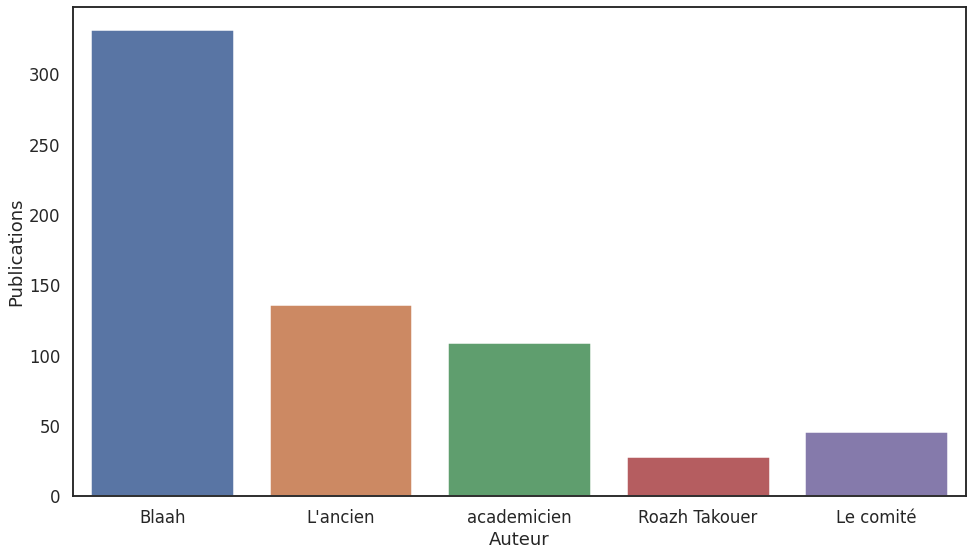

In [150]:
_ = sns.countplot(x="Auteur", data=df)
_ = plt.ylabel("Publications")

In [163]:
alt.Chart(df[["Auteur", "Publications"]]).mark_bar().encode(
    x=alt.X(
        "Auteur:N",
        axis=alt.Axis(labelAngle=0)
    ),
    y=alt.Y(
        "count(Publications):Q",
        axis=alt.Axis(title="Nombre d'académies")
    ),
    color="Auteur:N"
).properties(
    width=800
)

alt.Chart(...)

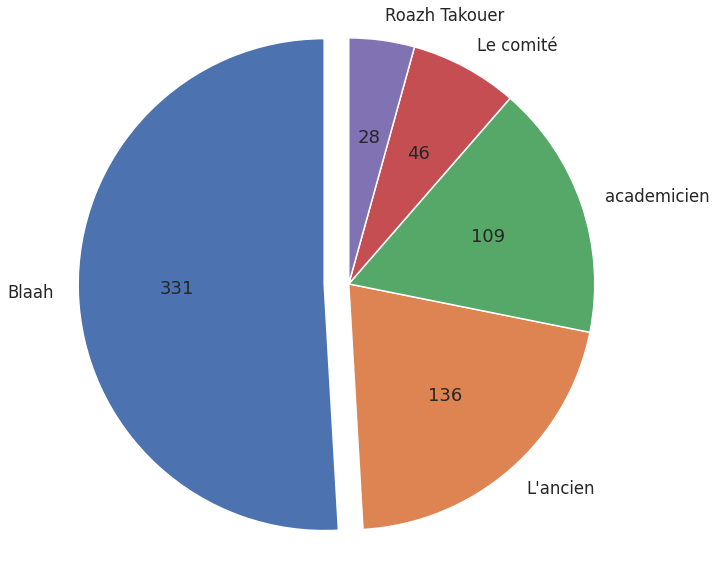

In [5]:
# List of authors
authors = df['Auteur'].value_counts().reset_index().values
list_of_authors = [x[0] for x in authors]

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = [x[1] for x in authors]
explode = (0.1, 0, 0, 0, 0) 
total = sum(sizes)

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(sizes, explode=explode, labels=list_of_authors,
        autopct=lambda p: '{:.0f}'.format(p * total / 100),
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Publications par Année

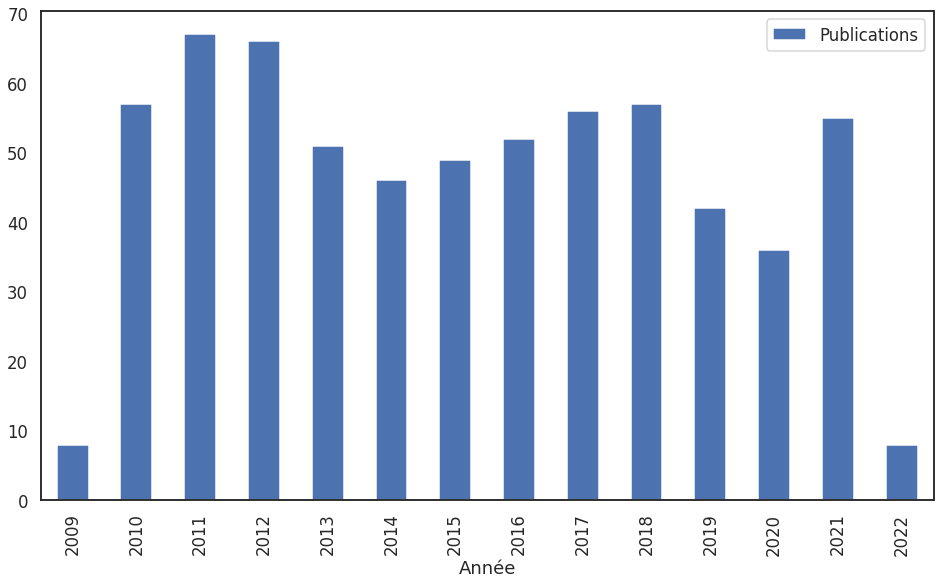

In [6]:
_ = df.groupby("Année").agg({"Publications": "sum"}).plot.bar()

## Publications par Année et Auteur

In [7]:
pivot = df.pivot_table(index="Année", columns="Auteur", values="Publications", aggfunc={"Publications": np.sum})

In [8]:
pivot_pct = pivot.apply(lambda x: x * 100.0 / x.sum(), axis=1)

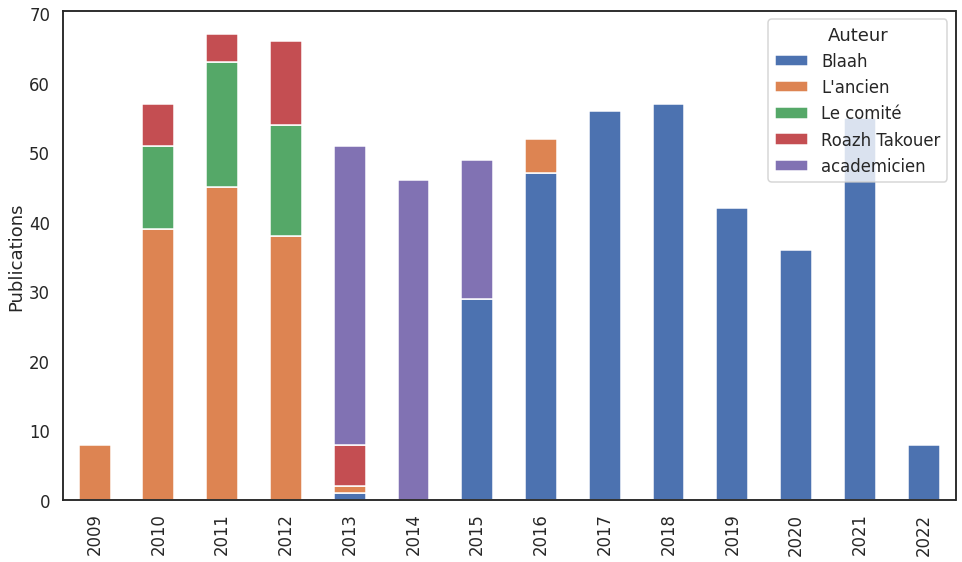

In [9]:
_ = pivot.plot.bar(stacked=True)
_ = plt.ylabel("Publications")
_ = plt.xlabel("")

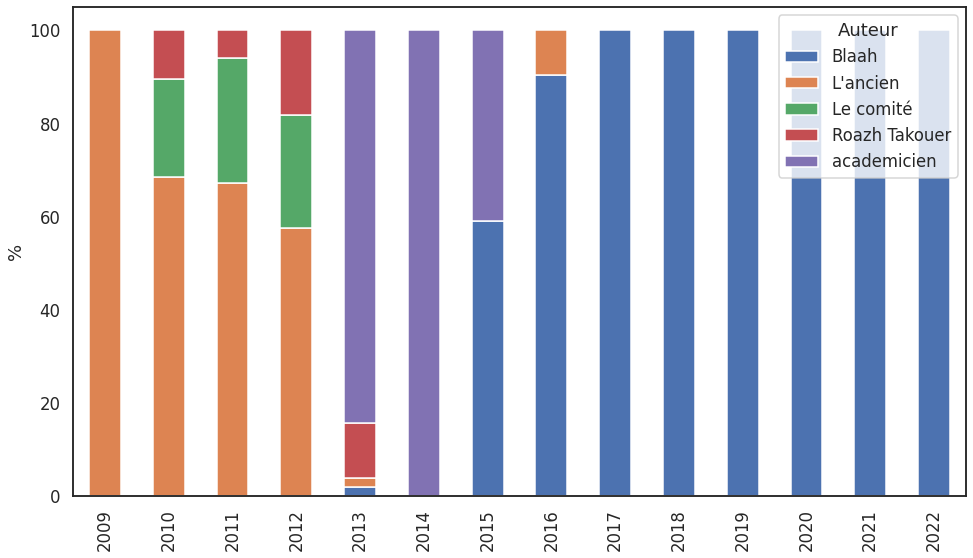

In [10]:
_ = pivot_pct.plot.bar(stacked=True)
_ = plt.ylabel("%")
_ = plt.xlabel("")

## Longueur du texte par auteur

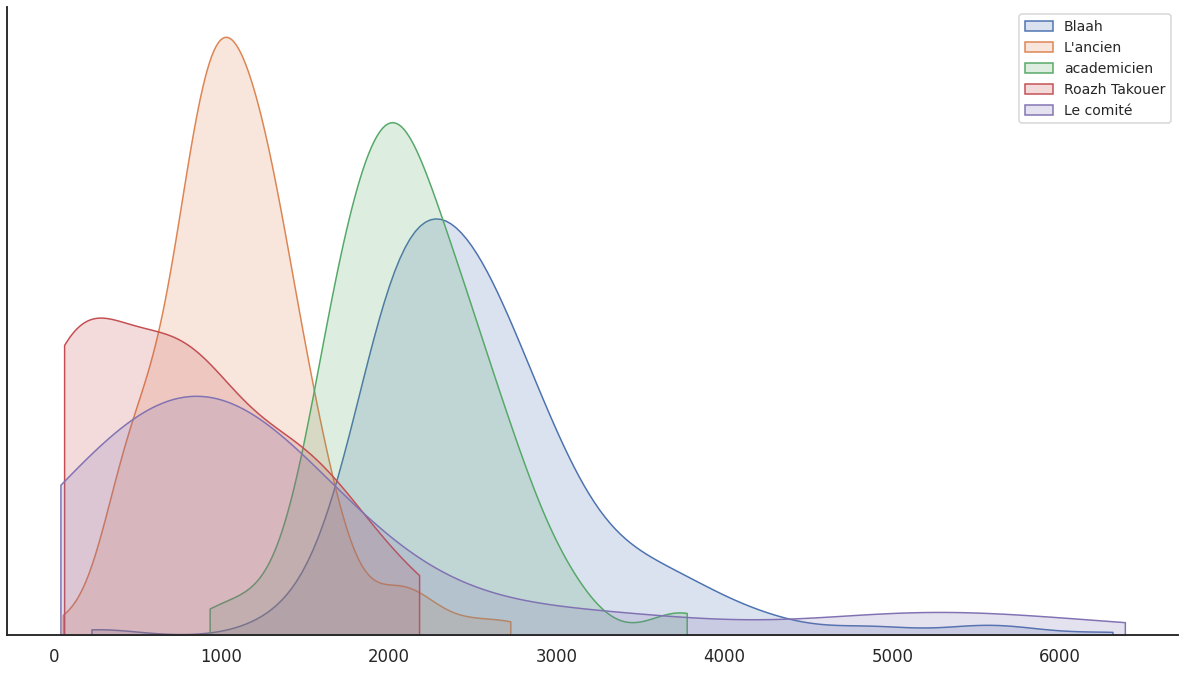

In [11]:
# Draw the density plot
g = sns.FacetGrid(df, hue="Auteur", height=10, aspect=16.0/9.0)
g = (g.map(sns.kdeplot, "nb_tokens", cut=0, fill=True, alpha=0.2, common_norm=True))
    
# Plot formatting
plt.legend(prop={'size': 14})
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.yticks([])

plt.show()

In [12]:
alt.Chart(df[["Auteur", "nb_tokens"]]).transform_density(
    'nb_tokens',
    as_=['Nombre de Mots', 'density'],
    extent=[0, 6000],
    groupby=['Auteur']
).mark_area(orient='horizontal').encode(
    y='Nombre de Mots:Q',
    color='Auteur:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
    ),
    column=alt.Column(
        'Auteur:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
            labelFontWeight="bold",
            labelBaseline="bottom"
        ),
    )
).properties(
    width=200
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

alt.Chart(...)



___


# Blaah l'académicien

* 331 académies, 48512 phrases, 850787 mots

In [13]:
df = df.set_index("Auteur")
blaah = df.loc["Blaah"].copy().reset_index(drop=True)

## Mots les plus utilisés

In [14]:
lemmatizer = FrenchLefffLemmatizer()

def lemmatize(x: spacy.tokens.Token) -> str:
    pos_2_leff = {
        "VERB": "v",
        "NOUN": "n",
        "ADJ": "a"
    }
    leff_pos = pos_2_leff.get(x.pos_, "n")
    return lemmatizer.lemmatize(word=x.lemma_, pos=leff_pos)

corpus = [[lemmatize(t) for t in doc if not t.is_stop and not t.is_space and len(t) > 2] for doc in blaah["docs"]]
dic = Dictionary(documents=corpus)

## Mots utilisés dans le plus d'académies

In [15]:
dfs = pd.DataFrame([{"word": dic[k], "dfs": v} for k, v in dic.dfs.items()])

alt.Chart(dfs[:100]).mark_bar().encode(
    y=alt.Y("dfs:Q", title="Nombre d'académies utilisant le mot"),
    x=alt.X(
        "word:O", 
        sort=alt.EncodingSortField(field="dfs", order="descending"),
        axis=alt.Axis(labelAngle=-45),
        title="Mot"
    ),
    color=alt.Color("dfs", scale=alt.Scale(scheme="redyellowgreen")),
    tooltip=[alt.Tooltip(field="word", title="Mot"), alt.Tooltip(field="dfs", title="# Académies")]
).properties(width=1200)

alt.Chart(...)

## Mots les plus fréquents

In [16]:
cfs = pd.DataFrame([{"word": dic[k], "cfs": v} for k, v in dic.cfs.items()])

alt.Chart(cfs[:100]).mark_bar().encode(
    y=alt.Y("cfs:Q", title="Nombre d'utilisations du mot"),
    x=alt.X(
        "word:O", 
        sort=alt.EncodingSortField(field="cfs", order="descending"),
        axis=alt.Axis(labelAngle=-45),
        title="Mot"
    ),
    color=alt.Color("cfs", scale=alt.Scale(scheme="redyellowgreen")),
    tooltip=[alt.Tooltip(field="word", title="Mot"), alt.Tooltip(field="cfs", title="# Utilisations")]
).properties(width=1200)

alt.Chart(...)

In [164]:
# Les Titres de Blaah

In [18]:
# * Le modèle: "xxx-OM (score), La Canebière académie VERBE COD..."
# * Lyon-OM (2-1), La Canebière académie ne tient pas la distance

In [19]:
home = re.compile(r"^\s*OM\s*[\-–]\s*(?P<adversaire>[\w\- ]+)")
away = re.compile(r"^\s*(?P<adversaire>[\w\- ]+)\s*[\-–]\s*OM")

In [20]:
# ## Les exceptions à la règle

# * Les académies de rétrospective
# * On les sort du corpus
# * Reste 318 académies

In [21]:
test = [(home.match(txt) is not None) is not (away.match(txt) is not None) for txt in blaah["Titre"]]

In [22]:
blaah = blaah.iloc[[x[0] for x in filter(lambda t: t[1], enumerate(test))]].copy()

In [23]:
def extract_adversaire(x):
    m = home.match(x)
    if m is None:
        m = away.match(x)

    if m is None:
        raise ValueError(f"Can't process {x}")
    return m.group("adversaire").strip()

blaah["Domicile"] = blaah["Titre"].apply(lambda x: home.match(x) is not None)
blaah["Adversaire"] = blaah["Titre"].apply(extract_adversaire)



___


# Scores (Extraits du Titre)

In [24]:
score = re.compile(r"^\s*\((?P<receveuse>\d+)\s*-\s*(?P<visiteuse>\d+).*\)")

In [25]:
def apres_equipes(x):
    m = home.match(x)
    if m is None:
        m = away.match(x)
    if m is None:
        raise ValueError(f"Can't process {x}")

    return x[m.end():]

In [26]:
def extract_buts(x):
    txt = apres_equipes(x)
    m = score.match(txt)
    if m is None:
        return pd.Series([np.nan, np.nan], index=["Buts_Receveuse", "Buts_Visiteuse"])
    return pd.Series([int(m.group("receveuse")), int(m.group("visiteuse"))], index=["Buts_Receveuse", "Buts_Visiteuse"])

In [27]:
buts = blaah["Titre"].apply(extract_buts)
blaah[["Buts_R", "Buts_V"]] = buts
blaah["Buts_OM"] = blaah.apply(lambda x: x["Buts_R"] if x["Domicile"] else x["Buts_V"], axis=1)
blaah["Buts_Adversaire"] = blaah.apply(lambda x: x["Buts_V"] if x["Domicile"] else x["Buts_R"], axis=1)
blaah.drop(columns=["Buts_R", "Buts_V"], inplace=True)
blaah.dropna(subset=["Buts_OM", "Buts_Adversaire"], inplace=True)
for col in ["Buts_OM", "Buts_Adversaire"]:
    blaah[col] = blaah[col].astype(int)

In [28]:
def resultat(x):
    om = x["Buts_OM"]
    adv = x["Buts_Adversaire"]

    if om > adv:
        return "Victoire"
    if om == adv:
        return "Nul"
    return "Défaite"

blaah["Résultat"] = blaah.apply(resultat, axis=1)

In [29]:
blaah = pd.concat([blaah, pd.get_dummies(blaah["Résultat"])], axis=1)

### Victoires / Nuls / Défaites

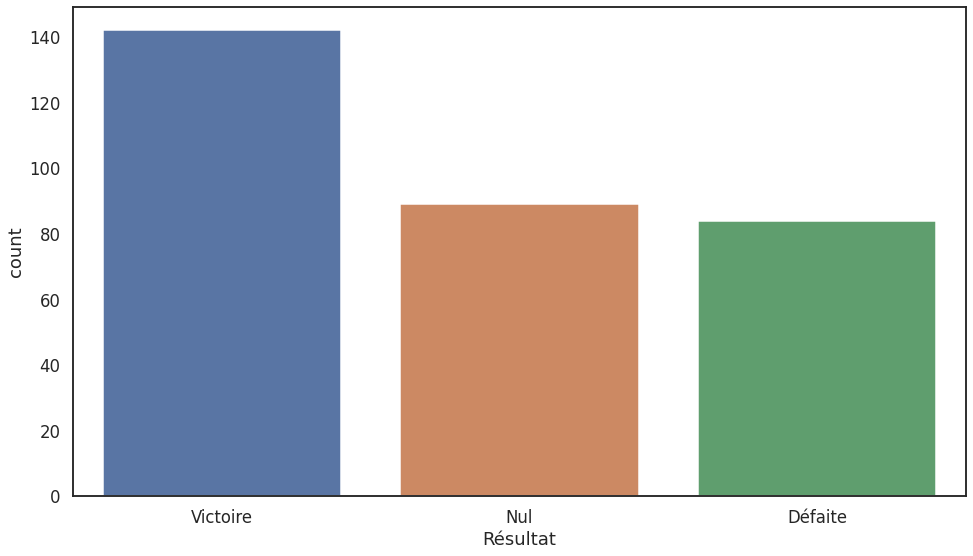

In [30]:
_ = sns.countplot(x="Résultat", data=blaah)

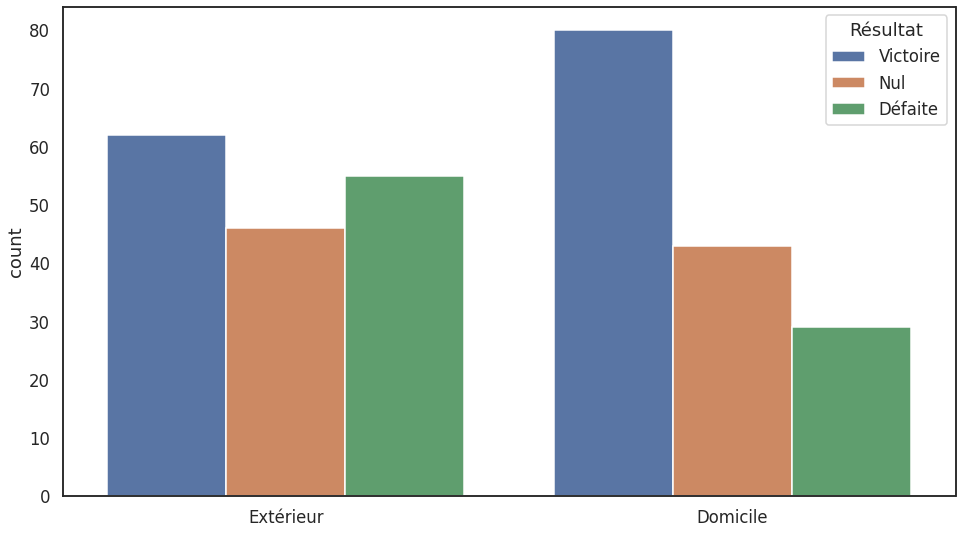

In [31]:
_ = sns.countplot(x="Domicile", hue="Résultat", data=blaah)
_ = plt.xticks(ticks=[True, False], labels=["Domicile", "Extérieur"])
_ = plt.xlabel("")

### Nombre de buts dans les matches

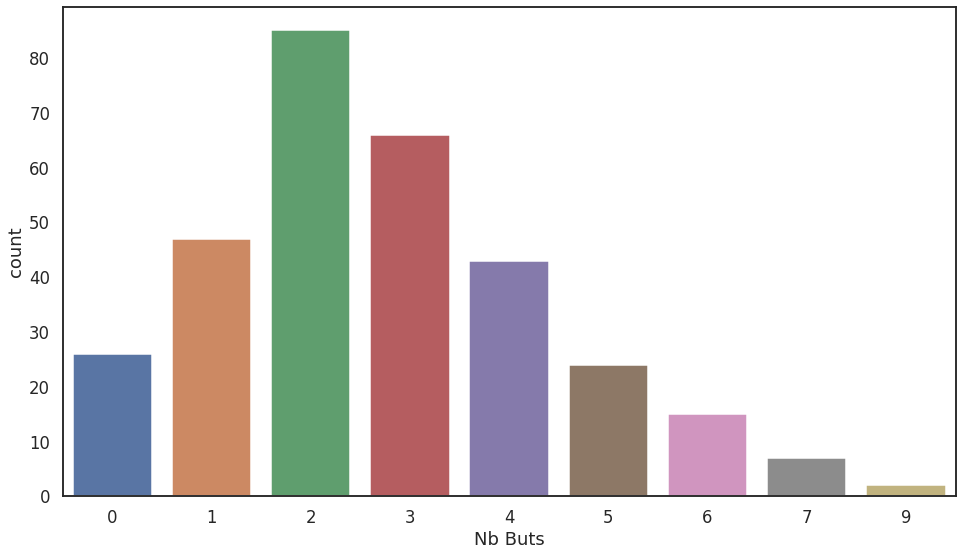

In [32]:
blaah["Nb Buts"] = blaah["Buts_OM"] + blaah["Buts_Adversaire"]
_ = sns.countplot(x="Nb Buts", data=blaah)

### Nombre de buts de l'OM

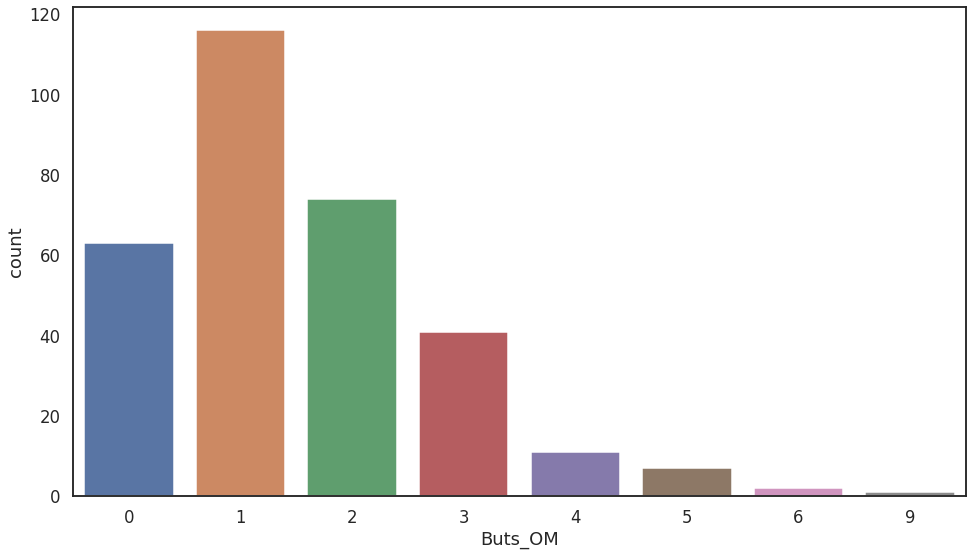

In [33]:
_ = sns.countplot(x="Buts_OM", data=blaah)

### Nombre de buts de l'adversaire

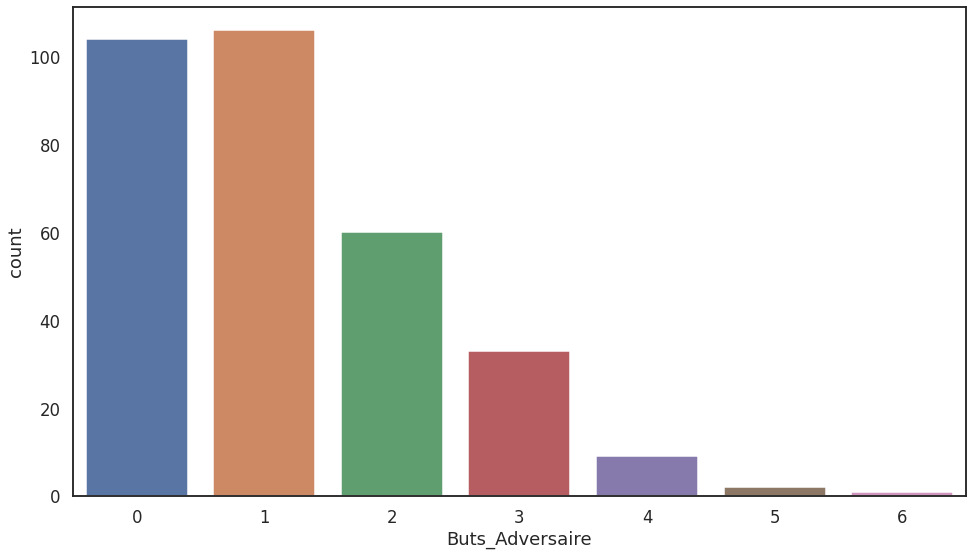

In [34]:
_ = sns.countplot(x="Buts_Adversaire", data=blaah)

### Différence de But par Adversaire

In [35]:
by_adv = blaah.groupby("Adversaire").agg({"Publications": "sum"})

In [36]:
# Il va falloir traiter les doublons...

# * ASSE / Saint-Etienne / Saint-Étienne
# * TFC / Toulouse
# * MHSC / Montpellier
# * Gazélec / Gazéléc
# * Konyaspot / Konyasport
# * Salzbourg / Salzburg
# * Athletic / Bilbao

In [37]:
normalize = [
    {"dups": ["ASSE", "Saint-Etienne", "Saint-Étienne"], "norm": "Saint-Étienne"},
    {"dups": ["TFC", "Toulouse"], "norm": "Toulouse"},
    {"dups": ["MHSC", "Montpellier"], "norm": "Montpellier"},
    {"dups": ["Gazélec", "Gazéléc"], "norm": "Gazélec Ajaccio"},
    {"dups": ["Konyaspor", "Konyasport"], "norm": "Konyaspor"},
    {"dups": ["Salzbourg", "Salzburg"], "norm": "Salzburg"},
    {"dups": ["Athletic", "Bilbao"], "norm": "Athletic Bilbao"},
    {"dups": ["Atlético"], "norm": "Atletico Madrid"}
]

In [38]:
for dedup in normalize:
    blaah.loc[blaah["Adversaire"].isin(dedup["dups"]), "Adversaire"] = dedup["norm"]

In [39]:
by_adv = blaah.groupby("Adversaire").agg({"Publications": "sum", "Buts_OM": "sum", "Buts_Adversaire": "sum"})
by_adv.reset_index(inplace=True)

In [40]:
by_adv["Différence de Buts"] = by_adv["Buts_OM"] - by_adv["Buts_Adversaire"]

In [41]:
slider = alt.binding_range(min=by_adv["Publications"].min(), max=by_adv["Publications"].max(), step=1, name="Nombre Minimum de Matchs: ")
select_nb_matches = alt.selection_single(name="matches", fields=["Publications"], bind=slider, init={"Publications": 0})

alt.Chart(by_adv).mark_bar().encode(
    y="Différence de Buts:Q",
    x=alt.X(
        "Adversaire:O", 
        sort=alt.EncodingSortField(field="Différence de Buts"),
        axis=alt.Axis(labelAngle=-45)
    ),
    color=alt.Color("Différence de Buts", scale=alt.Scale(scheme="redyellowgreen")),
    tooltip=["Adversaire", "Différence de Buts", "Publications"]
).add_selection(
    select_nb_matches
).transform_filter(
    "datum.Publications >= matches_Publications"
). properties(height=600,width=1200)

alt.Chart(...)

### Différentiel Victoire / Défaite par Adversaire

In [42]:
by_adv = blaah.groupby("Adversaire").agg({"Publications": "sum", "Victoire": "sum", "Défaite": "sum", "Nul": "sum"})
by_adv.reset_index(inplace=True)
by_adv["Différence Victoire / Défaite"] = by_adv["Victoire"].astype(int) - by_adv["Défaite"].astype(int)

In [43]:
chart = alt.Chart(by_adv).mark_bar().encode(
    y="Différence Victoire / Défaite",
    x=alt.X(
        "Adversaire:O", 
        sort=alt.EncodingSortField(field="Différence Victoire / Défaite"),
        axis=alt.Axis(labelAngle=-45)
    ),
    color=alt.Color("Différence Victoire / Défaite", scale=alt.Scale(scheme="redyellowgreen")),
    tooltip=["Adversaire", "Victoire", "Nul", "Défaite", "Publications"]
).add_selection(
    select_nb_matches
).transform_filter(
    "datum.Publications >= matches_Publications"
). properties(height=600,width=1200)

chart

alt.Chart(...)



___


# Les Verbes dans les Titres

In [44]:
blaah["Titre_Part2"] = blaah["Titre"].str.lower().str.extract(r"^.+(la\s+canebière\s+académiq?u?e[\w\s]+)")

In [45]:
blaah = blaah.dropna(subset=["Titre_Part2"])

In [46]:
blaah["Titre_Part2"] = blaah["Titre_Part2"].str.replace(r"la\s+canebière\s+académiq?u?e", "elle", regex=True)

In [47]:
fr = spacy.load('fr_core_news_sm')

In [48]:
blaah["Titre_Part2_doc"] = blaah["Titre_Part2"].apply(fr)

In [49]:
def extract_verb(x):
    v = [t.lemma_ for t in x if t.pos_ == "VERB"]
    if len(v) == 0:
        return np.nan
    return lemmatizer.lemmatize(v[0], "v")

blaah["Verbe"] = blaah["Titre_Part2_doc"].apply(extract_verb)

In [50]:
chart = alt.Chart(blaah[["Verbe", "Publications"]].dropna()).mark_bar().encode(
    x=alt.X(
        field="Verbe", 
        type="ordinal", 
        sort=alt.EncodingSortField(field="Occurences", order="descending"),
        axis=alt.Axis(labelAngle=-45, labelFontSize=14)
    ),
    y="Occurences:Q",
    color=alt.Color("Occurences:Q", scale=alt.Scale(scheme="greenblue")),
    tooltip=["Verbe", "Occurences:Q"]
).transform_aggregate(
    groupby=["Verbe"],
    Occurences="sum(Publications)"
).transform_filter(
    alt.datum.Occurences >= 1
)

chart.configure_header(
    titleColor='green',
    titleFontSize=14,
    labelColor='red',
    labelFontSize=14
)

chart

alt.Chart(...)



___


# Les Notes (Extraites du texte de l'académie)

In [51]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(blaah.iloc[0]["html"])

In [52]:
notes_re = re.compile(r"^(?P<joueur>[\w\s]+) \(.*,?\w*(?P<note>\d[\+\-]?)/5.*")
note_num = re.compile(r"^(?P<num>\d+)(?P<plus>[\+\-]?)$")

def extract_notes(row: pd.Series) -> pd.DataFrame:
    adversaire = row["Adversaire"]
    date = row["Date"]
    soup = BeautifulSoup(row["html"])
    data = []
    for st in soup.find_all(["strong", "b", "i", "em"]):
        m = notes_re.match(st.text)
        if m is None:
            continue
        
        m_num = note_num.match(m.group("note"))
        if m_num is None:
            continue
        
        plus_moins = m_num.group("plus")
        note_ = float(m_num.group("num")) + 0.5 * (-1 if plus_moins == "-" else 1)
        data.append({"Adversaire": adversaire, "Date": date, "Joueur": m.group("joueur").replace("\n", " ").strip().title(), "Note (texte)": m.group("note"), "Note (nombre)": note_})
    return pd.DataFrame(data)



In [54]:
notes = pd.concat(blaah.apply(extract_notes, axis=1).values)

In [75]:
normalize = [
    {"dups": ["Amavi", "Amavier"], "norm": "Amavi"},
    {"dups": ["De Ceglie", "Détchéyé"], "norm": "De Ceglie"},
    {"dups": ["Leya Iseka", "Iseka Leya"], "norm": "Leya Iseka"},
    {"dups": ["Lopez", "Maxime Lopez"], "norm": "Lopez"},
    {"dups": ["Doria", "Diego Armando Maradoria"], "norm": "Doria"},
    {"dups": ["Njie", "Nvier"], "norm": "Njie"},
    {"dups": ["Batshuayi", "Michybre"], "norm": "Batshuayi"},
]

In [76]:
for dedup in normalize:
    notes.loc[notes["Joueur"].isin(dedup["dups"]), "Joueur"] = dedup["norm"]

In [77]:
stats = pd.DataFrame({"Académie": ["Académie", "Académie"], "Notes": ["Récupérées", "Non Récupérées"], "Nombre": [notes["Date"].nunique(), blaah.shape[0] - notes["Date"].nunique()]})

alt.Chart(stats).mark_bar().encode(
    x=alt.X("Académie:N", axis=alt.Axis(labels=False)),
    y=alt.Y("Nombre:Q", stack="zero"),
    color=alt.Color("Notes:N", legend=alt.Legend(title="Récupération Automatique"), scale=alt.Scale(domain=["Récupérées", "Non Récupérées"], range=["green", "red"])),
    tooltip="Nombre:Q"
)

alt.Chart(...)

In [78]:
by_joueur = notes.groupby("Joueur").agg({"Note (nombre)": ["count", "mean"]})
by_joueur.columns = by_joueur.columns.droplevel()
by_joueur.reset_index(inplace=True)

In [80]:
chart = alt.Chart(by_joueur).mark_bar().encode(
    x=alt.X(
        field="Joueur", 
        type="ordinal", 
        sort=alt.EncodingSortField(field="count", order="descending"),
        axis=alt.Axis(labelAngle=-45, labelFontSize=14)
    ),
    y=alt.Y("count:Q", title="Nombre de Notes"),
    color=alt.Color("count:Q", scale=alt.Scale(scheme="greenblue")),
    tooltip=["Joueur", alt.Tooltip("count:Q", title="# Notes")]
)

chart.configure_header(
    titleColor='green',
    titleFontSize=14,
    labelColor='red',
    labelFontSize=14
)

chart

alt.Chart(...)

In [146]:
slider = alt.binding_range(min=by_joueur["count"].min(), max=by_joueur["count"].max(), step=1, name="Nombre Minimum de Notes: ")
select_nb_matches = alt.selection_single(name="matches", fields=["count"], bind=slider, init={"count": 1})

chart = alt.Chart(by_joueur).mark_bar().encode(
    x=alt.X(
        field="Joueur", 
        type="ordinal", 
        sort=alt.EncodingSortField(field="mean", order="descending"),
        axis=alt.Axis(labelAngle=-45, labelFontSize=14)
    ),
    y=alt.Y("mean:Q", title="Moyenne"),
    color=alt.Color("mean:Q", scale=alt.Scale(scheme="redyellowgreen", domain=[0.0, 5.0])),
    tooltip=["Joueur", alt.Tooltip("count:Q", title="# Notes"), alt.Tooltip("mean:Q", title="Moyenne")]
).add_selection(
    select_nb_matches
).transform_filter(
    'datum.count >= matches_count'
)

chart.configure_header(
    titleColor='green',
    titleFontSize=14,
    labelColor='red',
    labelFontSize=14
)

chart

alt.Chart(...)

In [83]:
nb_notes = notes["Joueur"].value_counts()

alt.Chart(notes[notes["Joueur"].isin(nb_notes[nb_notes >= 10].index)][["Joueur", "Note (nombre)"]]).transform_density(
    'Note (nombre)',
    as_=['Note', 'density'],
    extent=[0, 5],
    groupby=['Joueur']
).mark_area(orient='horizontal').encode(
    y='Note:Q',
    color='Joueur:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
    ),
    column=alt.Column(
        'Joueur:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
            labelFontWeight="bold",
            labelBaseline="bottom",
            labelAngle=-45
        ),
    )
).properties(
    width=50
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

alt.Chart(...)

In [119]:
by_joueur_by_note = notes.groupby(["Joueur", "Note (nombre)"]).agg({"Date": "count"})
by_joueur_by_note = by_joueur_by_note.reset_index()
by_joueur_by_note.columns = ["Joueur", "Note", "count"]

In [120]:
alt.Chart(by_joueur_by_note, width=1200).mark_bar().encode(
    x=alt.X(
        'Joueur:N',
        title=None,
        axis=alt.Axis(labelAngle=-45),
        scale=alt.Scale(),
    ),
    y=alt.Y(
        'Note:Q', 
        stack="normalize", 
        axis=alt.Axis(labels=False, ticks=False),
        title=""
    ),
    order=alt.Order("Note:Q", sort="ascending"),
    color=alt.Color('Note:Q', scale=alt.Scale(scheme="redyellowgreen", domain=[0.0, 5.0])),
    tooltip=["Joueur", "Note", "count"]
)

alt.Chart(...)

In [60]:
notes["Match"] = notes["Adversaire"] + " " + notes["Date"].dt.strftime("%d/%m/%Y")
notes["sort"] = notes["Date"].dt.strftime("%Y%m%d")
notes["count"] = 1

In [144]:
alt.Chart(notes).mark_point(shape="square", size=2).encode(
    x=alt.X(
        "Match:O",
        sort=alt.EncodingSortField("sort", order="ascending"), 
        axis=alt.Axis(labels=False, ticks=False)
        ),
    y=alt.Y(
        "Joueur:N",
        axis=alt.Axis(labels=False, ticks=False)
        ),
    color=alt.Color("Note (nombre):Q", scale=alt.Scale(scheme="redyellowgreen")),
    #size=alt.Size("count:Q", ),
    tooltip=["Joueur", "Note (nombre)", "Adversaire", "Date"]
).properties(
    height=400,
    width=1200
)

alt.Chart(...)

In [145]:
width = 1200
nb_matches = notes["Match"].nunique()
nb_joueurs = notes["Joueur"].nunique()

select_joueurs = alt.selection_multi(fields=["Joueur"])

joueurs = alt.Chart(pd.DataFrame({"Joueur": notes["Joueur"].unique()})).mark_rect().encode(
    x=alt.X(
        "Joueur:N",
        axis=alt.Axis(labelAngle=-45),
    ),
    color=alt.condition(select_joueurs, alt.Color('Joueur:N', legend=None), alt.value('lightgray'))
).add_selection(
    select_joueurs
).properties(
    width=width
)

heatmap = alt.Chart(notes).mark_point(shape="square", size=2).encode(
    x=alt.X(
        "Match:O",
        sort=alt.EncodingSortField("sort", order="ascending"), 
        axis=alt.Axis(labels=False, ticks=False)
        ),
    y=alt.Y(
        "Joueur:N",
        axis=alt.Axis(labels=False, ticks=False)
        ),
    color=alt.Color("Note (nombre):Q", scale=alt.Scale(scheme="redyellowgreen")),
    #size=alt.Size("count:Q", ),
    tooltip=["Joueur", "Note (nombre)", "Adversaire", "Date"]
).properties(
    height=400,
    width=width
).transform_filter(
    select_joueurs
)

joueurs & heatmap

alt.VConcatChart(...)